In [1]:
# imports
# imports
import networkx as nx
import pickle
import re
import numpy as np
import statistics
import powerlaw
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from functools import reduce

import json
from networkx.readwrite import json_graph

from collections import Counter
import math

# from community import community_louvain

import pandas as pd
import itertools
import re
import numpy as np
from bs4 import BeautifulSoup
import requests

In [4]:
df = pd.read_csv('../datasets/spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')

df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [83]:
# keep only 50% of the data
spotify_df = df.sample(frac=0.50, random_state=0)
spotify_df.dropna(inplace=True)
spotify_df.sort_values(by=['user_id'], inplace=True)
spotify_df = spotify_df.reset_index()
spotify_df = spotify_df.drop(columns=['index'])
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,00055176fea33f6e027cd3302289378b,Ed Sheeran,Photograph,favs
1,00055176fea33f6e027cd3302289378b,All Time Low,Break Your Little Heart,favs
2,00055176fea33f6e027cd3302289378b,5 Seconds Of Summer,If You Don't Know,favs
3,00055176fea33f6e027cd3302289378b,5 Seconds Of Summer,Long Way Home - Acoustic,favs
4,00055176fea33f6e027cd3302289378b,Avril Lavigne,Girlfriend,favs


Let's use the Genius API to get the song lyrics for each one of the sampled songs.

First, I'll import the packages and obtain the token I generated.

In [84]:
from lyricsgenius import Genius
token = "jzTsdHOsftMAX05GmCSBTRV7_ieLlu3rRypw7seoPGApjPGcMM-nL3pskaxraK2A"
genius = Genius(token)

Next, I'll obtain the song lyrics and other useful attributes for all the songs in the sampled dataframe.

In [72]:
# obtain the lyrics of a song
def obtain_lyrics(df):
    lyrics = []
    for title, artist in zip(df['trackname'], df['artistname']):
        song_lyrics = genius.search_song(title, artist).lyrics
        lyrics.append(song_lyrics)
    return pd.Series(lyrics)

# add lyrics column to the dataframe
def add_lyrics(df):
    df['lyrics'] = obtain_lyrics(df)
    return df

spotify_df = add_lyrics(spotify_df)
spotify_df.head()   

Searching for "Photograph" by Ed Sheeran...
Done.
Searching for "Break Your Little Heart" by All Time Low...
Done.
Searching for "If You Don't Know" by 5 Seconds Of Summer...
Done.
Searching for "Long Way Home - Acoustic" by 5 Seconds Of Summer...
Done.


,user_id,artistname,trackname,playlistname,lyrics
0,00055176fea33f6e027cd3302289378b,Ed Sheeran,Photograph,favs,TranslationsPortuguêsΕλληνικάPhotograph Lyrics...
1,00055176fea33f6e027cd3302289378b,All Time Low,Break Your Little Heart,favs,Break Your Little Heart Lyrics[Verse 1]\nWide ...
2,00055176fea33f6e027cd3302289378b,5 Seconds Of Summer,If You Don't Know,favs,If You Don’t Know Lyrics[Intro: Ashton]\nOh-oh...
3,00055176fea33f6e027cd3302289378b,5 Seconds Of Summer,Long Way Home - Acoustic,favs,Long Way Home (Acoustic) Lyrics[Intro: Luke]\n...


In [80]:
# clean the lyrics ie. convert to lowercase, remove brackets etc.

# remove texts in brackets
def remove_brackets(text):
    return re.sub("[\(\[].*?[\)\]]", "", text)

# remove punctuation
def remove_punctuation(text):
    return  " ".join(re.findall("[a-zA-Z]+", text))

def clean(df):
    df['lyrics'] = df['lyrics'].apply(lambda x: remove_brackets(x))
    df['lyrics'] = df['lyrics'].apply(lambda x: remove_punctuation(x))
    df['lyrics'] = df['lyrics'].apply(lambda x: x.lower()) # convert to lowercase
    return df

spotify_df = clean(spotify_df)
spotify_df.head()

The name of the artists who took part into a collaboration are separated by different characters: "&", "," or "/". So we chosen to split the artistname by these characters.

In [272]:
len(set(spotify_df.artistname))

219821

In [273]:
def preprocess_artistname():
    artists_set = set()
    artists = set(map(str.lower, spotify_df.artistname))
    for index, artist in enumerate(artists):
        # if index % 1000 == 0:
        #     print(index)
        group = True
        name_split = re.split('( and | & |, | \/ | feat. | ft. | featuring | with )', str(artist.lower()))
        for name in name_split:
            if name in artists:
                # check if artistname is not the name of an artistic group:
                artists_set.add(name)
                group = False
        if group == True:
            artists_set.add(artist)
    return artists_set

In [253]:
artists_set = preprocess_artistname()
len(artists_set)

189729

In [209]:
spotify_df.loc[spotify_df['artistname'].str.contains("his orchestra", case=False)]

,user_id,artistname,trackname,playlistname
8916514,00be8fa9d10f6318156fa753857597cf,Hugo Montenegro & His Orchestra,"The Good, The Bad and The Ugly",60s
8714093,02a3b8caebbd1c9965a03c9b27032fe1,Benny Goodman & His Orchestra,Blue Skies - Remastered 1991,Jazz
8714290,02a3b8caebbd1c9965a03c9b27032fe1,Tommy Dorsey & His Orchestra,The Continental,Jazz
1444156,0308284ac2d49b8692103f04b6ac741b,Ralph Sharon & His Orchestra,(I Left My Heart) In San Francisco,Italian dinner music
1444352,0308284ac2d49b8692103f04b6ac741b,Ralph Sharon & His Orchestra,"Sometimes I'm Happy (From Hit The Deck"")""",Italian dinner music
...,...,...,...,...
4618931,fa849dabeb14a2800ad5130907fc5018,Duke Ellington & His Orchestra,Madness In Great Ones,Jazz
4618337,fa849dabeb14a2800ad5130907fc5018,Peggy Lee with Dave Barbour And His Orchestra,I'm Gonna Wash That Man Right Out of My Hair,Jazz
10210182,fb2072384db58f154c359244ec0a9c5f,Benny Goodman & His Orchestra,"Sing, Sing, Sing",JZZ
7441714,fde18baf67c854b2b144c37cc27b8d11,Chick Webb & His Orchestra,'Tain't What You Do (It's The Way That Cha Do It),Ella F.


In [254]:
track_df = spotify_df.drop_duplicates('trackname', keep='first').reset_index()
track_df.drop(["index", "user_id", "playlistname"], axis=1, inplace=True)
track_df.head()

,artistname,trackname
0,Ed Sheeran,Photograph
1,All Time Low,Break Your Little Heart
2,5 Seconds Of Summer,If You Don't Know
3,5 Seconds Of Summer,Long Way Home - Acoustic
4,Avril Lavigne,Girlfriend


In [218]:
# construct artists data set, where each artist have a list with associated tracks
def build_artist_dict(artists_set, track_df):
    artists_dict = dict((k, set()) for k in artists_set)
    
    for _, track in track_df.iterrows():
        group = True
        name_split = re.split('( and | & |, | \/ | feat. | ft. | featuring | with )', str(track.artistname.lower()))
        for name in name_split:
            if name in artists_set:
                # check if artistname is not the name of an artistic group:
                artists_dict[name].add(track.trackname)
                group = False
        if group == True:
            artists_dict[track.artistname.lower()].add(track.trackname)
    return artists_dict

In [255]:
artists_dict = build_artist_dict(artists_set, track_df)

In [150]:
def build_track_dict(artists_set, track_df):
    song_dict = dict((k, set()) for k in track_df.trackname)
    
    for _, track in track_df.iterrows():
        group = True
        name_split = re.split('( and | & |, | \/ | feat. | ft. | featuring | with )', str(track.artistname.lower()))
        for name in name_split:
            if name in artists_set:
                # check if artistname is not the name of an artistic group:
                song_dict[track.trackname].add(name)
                group = False
        if group == True:
            song_dict[track.trackname].add(track.artistname.lower())
    return song_dict

In [256]:
track_dict = build_track_dict(artists_set, track_df)

In [257]:
import networkx as nx
# construct artist network
artists_graph = nx.Graph()
artists_graph.add_nodes_from(artists_set)

In [258]:
for artists in track_dict.values():
    artists_list = list(artists)
    for i in range(len(artists_list) - 1):
        for j in range(i+1, len(artists_list)):
            artists_graph.add_edge(artists_list[i], artists_list[j])

In [259]:
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))

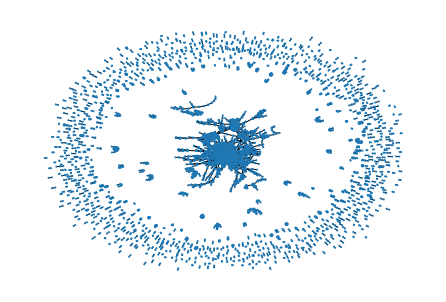

In [194]:
nx.draw(artists_graph, node_size=list(dict(artists_graph.degree()).values()))

In [260]:
len(artists_graph.nodes())

10504

In [261]:
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
G0 = artists_graph.subgraph(Gcc[0])

In [262]:
len(G0.nodes())

4740

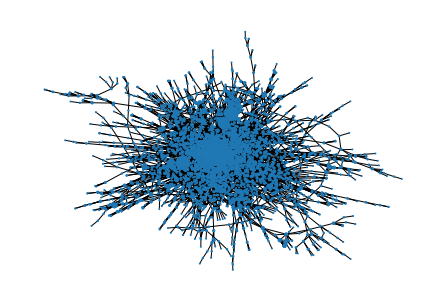

In [263]:
nx.draw(G0, node_size=list(dict(G0.degree()).values()))

In [264]:
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(G0, random_state=0) 
# we used random_state parameter so that the results can be reproduced

In [265]:
mod = community_louvain.modularity(communities, G0)
print("modularity is", mod)

modularity is 0.8542937726810862


In [266]:
no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

The Louvain algorithm had found 67 communities
The community 0 has 577 nodes
The community 22 has 306 nodes
The community 3 has 241 nodes
The community 11 has 218 nodes
The community 53 has 193 nodes
The community 35 has 149 nodes
The community 30 has 141 nodes
The community 29 has 137 nodes
The community 17 has 135 nodes
The community 59 has 121 nodes
The community 55 has 112 nodes
The community 41 has 110 nodes
The community 31 has 104 nodes
The community 18 has 102 nodes
The community 51 has 99 nodes
The community 2 has 94 nodes
The community 24 has 93 nodes
The community 44 has 92 nodes
The community 12 has 92 nodes
The community 37 has 84 nodes
The community 7 has 78 nodes
The community 9 has 77 nodes
The community 26 has 74 nodes
The community 8 has 74 nodes
The community 57 has 74 nodes
The community 61 has 61 nodes
The community 42 has 60 nodes
The community 65 has 59 nodes
The community 1 has 56 nodes
The community 34 has 56 nodes
The community 13 has 55 nodes
The community 4 

In [274]:
[k for k,v in communities.items() if v == 0]

['kidd kidd',
 'daz',
 'nate dogg',
 'the pack',
 'bobby valentino',
 'chester french',
 'pullout',
 'david bisbal',
 'jason crabb',
 'baby',
 'juanes',
 'bono',
 'dario g',
 'solange',
 'havoc',
 'boyz n da hood',
 'yung redd',
 'josh groban',
 'the edge',
 'yung joc',
 'big d',
 'michael mind',
 'b.o.b.',
 'rise at night',
 'nina sky',
 'my darkest days',
 'trae',
 'dj storm',
 'chingy',
 'justin timberlake',
 'sisqo',
 'rahzel',
 'next',
 'tamar braxton',
 'alejandro sanz',
 'collio',
 'tok',
 'hurricane g',
 'india arie',
 'princess',
 'offspring',
 'nelly furtado',
 'mack maine',
 'red cafe',
 'jonas brothers',
 'faith evans',
 'britney spears',
 'magoo',
 'young jeezy',
 'project pat',
 'diddy',
 'the notorious b.i.g.',
 'lady gaga',
 'young dro',
 'lil wayne',
 'wacka flocka flame',
 'young buck',
 'nic',
 'wc',
 'bg',
 'spragga benz',
 'akon',
 'alaine',
 'gipp',
 'lloyd',
 'tate',
 'yukmouth',
 'joe moses',
 'jake one',
 'jamie foxx',
 'mf grimm',
 "lil' jon",
 'jennifer lópez

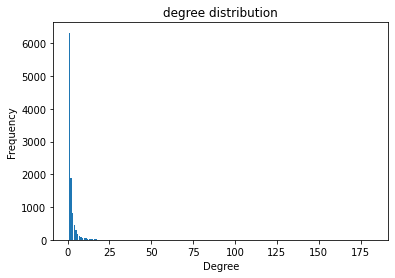

In [280]:
# Plot degree distribution
degree = list(dict(artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1,2, figsize=(15,5))
plt.title('degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

In [291]:
subset_artists = list(G0.nodes())

In [292]:
len(subset_artists)

4740

In [281]:
def get_track_artists(artists_set, spotify_df):
    track_artists_list = []
    
    for _, track in spotify_df.iterrows():
        group = True
        name_split = re.split('( and | & |, | \/ | feat. | ft. | featuring | with )', str(track.artistname.lower()))
        for name in name_split:
            if name in artists_set:
                # check if artistname is not the name of an artistic group:
                track_artists_list.append(name_split)
                group = False
                break
        if group == True:
            track_artists_list.append([track.artistname.lower()])
    return track_artists_list

In [293]:
def build_users_dict(spotify_df):
    users_dict = dict((k, set()) for k in spotify_df.user_id)
    user_song_dict = dict((k, list()) for k in spotify_df.user_id)
    user_artists_dict = dict((k, list()) for k in spotify_df.user_id)
    for _, entry in spotify_df.iterrows():
        group = True
        name_split = re.split('( and | & |, | \/ | feat. | ft. | featuring | with )', str(entry.artistname.lower()))
        for name in name_split:
            if name in subset_artists:
                # check if artistname is not the name of an artistic group:
                user_song_dict[entry.user_id].append((entry.trackname, name_split))
                user_artists_dict[entry.user_id] += name_split
                group = False
                break
        if group is True:
            user_song_dict[entry.user_id].append((entry.trackname, [entry.artistname.lower()]))
            user_artists_dict[entry.user_id] += [entry.artistname.lower()]
    return user_song_dict, user_artists_dict


In [294]:
user_song_dict, user_artists_dict = build_users_dict(spotify_df)